In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding,Flatten,SimpleRNN
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
def get_score(valid_y_exp, pred):
    return mean_absolute_error(pred, valid_y_exp)

In [3]:
path = "Dataset/AAl_T_Weather_SkewFix_19des-22mar.csv"

df_data = pd.read_csv(path)

In [4]:
df_data['Weekday'] = pd.to_datetime(df_data['Recorded']).dt.weekday
df_data['Hour'] = pd.to_datetime(df_data['Recorded']).dt.hour

In [5]:
df_data = df_data.drop(columns=["wdir_cardinal","Recorded"])

In [6]:
train_Df = df_data[0:35520]
train_Data = train_Df[0:28416]
val_df = train_Df[28416:]

In [7]:
X_train = train_Data[0:-1].copy()
Y_train = train_Data[["NO2","NOx","O3"]].copy()
Y_train = Y_train[1:]

In [8]:
X_val = val_df[0:-1].copy()
Y_val = val_df[["NO2","NOx","O3"]].copy()
Y_val = Y_val[1:]

In [9]:
Xscaler = StandardScaler()
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
Yscaler = StandardScaler()
Yscaler.fit(Y_train)
scaled_y_train = Yscaler.transform(Y_train)

In [10]:
X_val_scaler = StandardScaler() # scale so that all the X data will range from 0 to 1
X_val_scaler.fit(X_val)
scaled_X_val = X_val_scaler.transform(X_val)
Y_val_scaler = StandardScaler()
Y_val_scaler.fit(Y_val)
scaled_y_val = Y_val_scaler.transform(Y_val)

In [11]:
n_input = 48 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 256 # Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)
valgenerator = TimeseriesGenerator(scaled_X_val,scaled_y_val,length=n_input, batch_size=b_size)

In [12]:
model = Sequential()
#model.add(Embedding(input_dim=48,output_dim=48))
model.add(LSTM(64,activation='tanh', input_shape=(n_input, n_features)))#return_sequences=True))???will raise dimenson error
model.add(Dropout(0.5))
model.add(Dense(3, activation='tanh'))
#model.add(tf.keras.layers.Reshape([48, 3]))
model.compile(loss='mae',optimizer='adam')

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                19200     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 19,395
Trainable params: 19,395
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
111/111 - 6s - loss: 0.1463 - val_loss: 0.1026 - 6s/epoch - 57ms/step
Epoch 2/5
111/111 - 5s - loss: 0.0955 - val_loss: 0.1096 - 5s/epoch - 46ms/step
Epoch 3/5
111/111 - 5s - loss: 0.0835 - val_loss: 0.1029 - 5s/epoch - 46ms/step
Epoch 4/5
111/111 - 5s - loss: 0.0757 - val_loss: 0.0949 - 5s/epoch - 45ms/step
Epoch 5/5
111/111 - 5s - loss: 0.0711 - val_loss: 0.0906 - 5s/epoch - 45ms/step


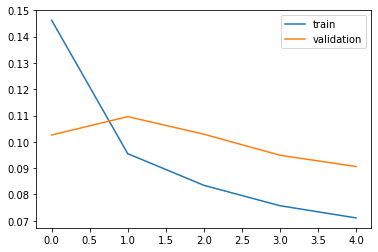

In [14]:
#model.fit(generator,epochs=5)
history = model.fit(generator, epochs=5, shuffle=False,
                        validation_data=(valgenerator),
                        #callbacks=[early_stopping],
                        verbose=2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()


In [15]:
prediction_scale = model.predict(valgenerator)
prediction = Y_val_scaler.inverse_transform(prediction_scale)
score = get_score(prediction,Y_val[48:].values)
score_scale = get_score(prediction_scale,scaled_y_val[48:])
print("val_loss Scaled:",score_scale)
print("val_loss normal:",score)


val_loss Scaled: 0.09063263577660811
val_loss normal: 6.348860813601238


 Computing LSTM Feature importance...



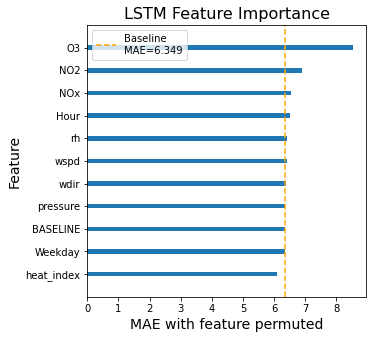

In [16]:
columnsTitles=train_Data.columns.to_list()
results = []
print(' Computing LSTM Feature importance...')
feature_preds_scale = model.predict(valgenerator, verbose = 0).squeeze()
feature_preds = Y_val_scaler.inverse_transform(feature_preds_scale)
baseline_mae = np.mean(np.abs(feature_preds - Y_val[48:].values))
results.append({'feature': 'BASELINE', 'mae': baseline_mae})

for i in range(len(columnsTitles)):
    save_col = scaled_X_val[:,i].copy()
    np.random.shuffle(scaled_X_val[:,i])
    feature_preds_scale = model.predict(valgenerator, verbose = 0).squeeze()
    feature_preds = Y_val_scaler.inverse_transform(feature_preds_scale)
    mae = np.mean(np.abs(feature_preds - Y_val[48:].values))
    results.append({'feature': columnsTitles[i], 'mae': mae})
    
    scaled_X_val[:,i] = save_col

print()
width = [0.2]
df = pd.DataFrame(results)
df = df.sort_values('mae')
plt.figure(figsize=(5,5))
plt.barh(np.arange(len(columnsTitles)+1),df.mae, width)
plt.yticks(np.arange(len(columnsTitles)+1),df.feature.values)
plt.title('LSTM Feature Importance',size=16)
plt.ylim((-1,len(columnsTitles)+1))
plt.plot([baseline_mae,baseline_mae],[-1,len(columnsTitles)+1], '--', color='orange',
                    label=f'Baseline \nMAE={baseline_mae:.3f}')
plt.xlabel('MAE with feature permuted',size=14)
plt.ylabel('Feature',size=14)
plt.legend()
plt.show()

In [17]:
test_df = df_data[35520: -6]
X_test = test_df.copy()
scaled_X_test = Xscaler.transform(X_test)
nplen = (X_test.shape[0],3)
npzeros = np.zeros(nplen)

In [18]:
test_generator = TimeseriesGenerator(scaled_X_test, npzeros, length=n_input, batch_size=b_size)

In [19]:
y_pred_scaled = model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)

In [20]:
NO2_pred = [i[0] for i in y_pred]
NOx_pred = [i[1] for i in y_pred]
O3_pred = [i[2] for i in y_pred]

In [21]:
predictionsDf = pd.DataFrame({"Pred_NO2":NO2_pred,"Pred_NOx":NOx_pred,"Pred_O3":O3_pred})
predictionsDf = predictionsDf.round(2)
predictionsDf.to_csv("LSTM/AAl_T_Prediction.csv",index=False)

In [22]:
NO2_real =test_df["NO2"].values
NOx_real =test_df["NOx"].values
O3_real =test_df["O3"].values

In [23]:
realDF = pd.DataFrame({"Real_NO2":NO2_real,"Real_NOx":NOx_real,"Real_O3":O3_real})
realDF.to_csv("LSTM/AAl_T_Real.csv",index=False)

In [24]:
score = get_score(NO2_real[48:],NO2_pred)
score
#1.963623620451355 relu linear
#1.7938049322538414 tanh tanh

3.4290185905973796

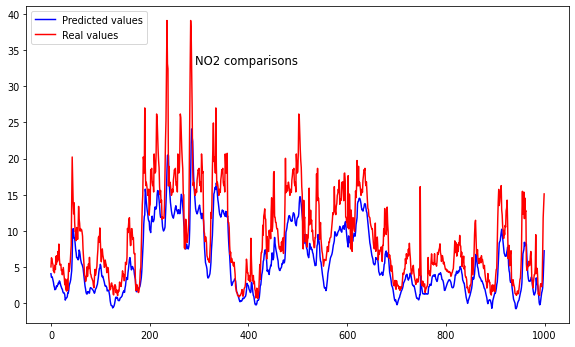

In [25]:
plt.figure(num=None, dpi=70, figsize=(10, 6),facecolor='w', edgecolor='k')
plt.plot(NO2_pred[0:1000], "-b", label="Predicted values")
plt.plot(NO2_real[48:1048], "-r", label="Real values")
plt.legend(loc="upper left")
plt.title('NO2 comparisons', x=0.5, y=0.8, loc='right')
plt.show()